# Summary

## This is a preliminary look at store sales data set from an old [Kaggle competition](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) hosted by WalMart. The competition asked for predictions on future dates relative to the training set.  

## While this data set was interesting from the perspective of seeing the sales dynamics of WalMart stores and their relative departments, after an initial look, I did not feel this gave the breadth of doing a machine learning project that I wanted mainly because the sales cycles were highly regular and none of the additional environmental features such as markdowns, fuel prices, unemployment rates, etc were actually needed.

## However, I did do a substantial amount of looking under the hood at the data and thought I would share it with whoever is also curious about WalMart sales data.  Spoiler alert:  They don't include actual department names, just department numbers so have fun trying to guess what each of them might be!

## This notebook will be continuously updated as I continue to play around with it.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

%matplotlib inline

from IPython.display import display, HTML
#from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
data = pd.read_csv('train.csv')
# Scale $ to $M
data.Weekly_Sales = data.Weekly_Sales/1e6
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,0.024924,False
1,1,1,2010-02-12,0.046039,True
2,1,1,2010-02-19,0.041596,False


In [4]:
test = pd.read_csv('test.csv')
test.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [5]:
data[(data.Store==1) & (data.Dept==1)].head(2)
stores = data.Store.max()
depts = data.Dept.max()
print(data.shape)

(421570, 5)


In [6]:
train = data
train['Store'] = 's' + train['Store'].astype(str)
train['Dept'] = 'd' + train['Dept'].astype(str)
train.head(2)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,s1,d1,2010-02-05,0.024924,False
1,s1,d1,2010-02-12,0.046039,True


In [7]:
ptrain1 = train.pivot_table(index='Date', columns=['Store','Dept'], values=['Weekly_Sales'])
ptrain1.reset_index(inplace=True)

print(ptrain1.shape)
ptrain1.head(1)


(143, 3332)


Date Weekly_Sales                                         \
Store                       s1                                          
Dept                        d1       d10       d11      d12       d13   
0      2010-02-05     0.024924  0.030721  0.024213  0.00845  0.041969   

                                             ...                      \
Store                                        ...        s9             
Dept        d14       d16       d17      d18 ...        d9       d90   
0      0.019467  0.010218  0.013224  0.00473 ...  0.007245  0.002336   

                                                                    
Store                                                               
Dept        d91      d92 d93 d94       d95       d96       d97 d98  
0      0.000293  0.01162 NaN NaN  0.023292  0.002438  0.000668 NaN  

[1 rows x 3332 columns]

In [8]:
storeindex = [u's1', u's10', u's11', u's12', u's13', u's14', u's15', u's16', u's17', u's18', u's19', u's2', u's20', u's21', u's22', u's23', u's24', u's25', u's26', u's27', u's28', u's29', u's3', u's30', u's31', u's32', u's33', u's34', u's35', u's36', u's37', u's38', u's39', u's4', u's40', u's41', u's42', u's43', u's44', u's45', u's5', u's6', u's7', u's8', u's9', u'']
stores = len(storeindex) - 1
print('Number of stores =',stores)

ptrain2 = train.pivot_table(index='Date', columns=['Store','Dept'], values=['IsHoliday'])
ptrain2.reset_index(inplace=True)
ptrain2.head(1)


Number of stores = 45


Date IsHoliday                                                   \
Store                    s1                                                    
Dept                     d1    d10    d11    d12    d13    d14    d16    d17   
0      2010-02-05     False  False  False  False  False  False  False  False   

             ...                                                              \
Store        ...      s9                                                       
Dept     d18 ...      d9    d90    d91    d92  d93  d94    d95    d96    d97   
0      False ...   False  False  False  False  NaN  NaN  False  False  False   

            
Store       
Dept   d98  
0      NaN  

[1 rows x 3332 columns]

### There are 45 stores represented in the database.

In [9]:
ptrain = ptrain1.merge(ptrain2)
pdata = ptrain.reset_index()
pdata.head(1)

index        Date Weekly_Sales                                         \
Store                             s1                                          
Dept                              d1       d10       d11      d12       d13   
0         0  2010-02-05     0.024924  0.030721  0.024213  0.00845  0.041969   

                                    ...  IsHoliday                            \
Store                               ...         s9                             
Dept        d14       d16       d17 ...         d9    d90    d91    d92  d93   
0      0.019467  0.010218  0.013224 ...      False  False  False  False  NaN   

                                      
Store                                 
Dept   d94    d95    d96    d97  d98  
0      NaN  False  False  False  NaN  

[1 rows x 6664 columns]

In [10]:
weeklysales = pdata[['Date','Weekly_Sales']]
weeklysales.head(1)
dates = weeklysales.loc[:,'Date']
#weeklysales.iloc[:, weeklysales.columns.get_level_values(2)=='d97']

In [11]:
# Summing sales per department over all stores
def deptsales(deptnum):
    return weeklysales.iloc[:, weeklysales.columns.get_level_values(2)==deptnum].sum(axis=1)
    
dept1 = pd.DataFrame.from_items([('Date',dates),('d1',deptsales('d1'))])
dept1.head(1)

,Date,d1
0,2010-02-05,0.881833


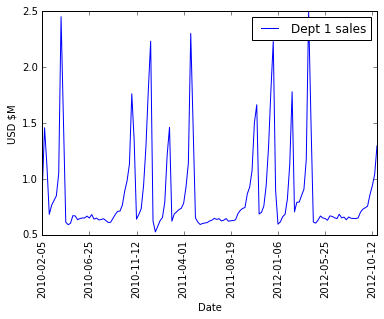

In [12]:
#fig, ax = plt.subplots()
#date = dept1.Date.values
#data = dept1.d1.values
#ax.plot(date, data)
#ax.plot(a, d, 'k:', label='Data length')
#ax.plot(a, c+d, 'k', label='Total message length')

# Now add the legend with some customizations.
#legend = ax.legend(loc='upper center', shadow=True)
ax = dept1.plot('Date','d1',rot=90,label='Dept 1 sales')
ax.set_ylabel('USD $M')

In [13]:
max = dept1['d1'].max()
min = dept1['d1'].min()
dept1ratio = max/min

In [14]:
# Sales peak detection
thresh = 0.5
dept1peaks = dept1[dept1['d1'] > dept1ratio*thresh*min]
holiday = pd.DataFrame.from_items([('Date',ptrain2['Date']),('IsHoliday',ptrain2[('IsHoliday','s1','d1')])])
peaks1 = pd.concat([dept1peaks['Date'], holiday.IsHoliday.iloc[dept1peaks.index]],axis=1)
peaks1.head()


,Date,IsHoliday
1,2010-02-12,True
8,2010-04-02,False
9,2010-04-09,False
38,2010-10-29,False
39,2010-11-05,False


### Department 1 sales, while tightly cyclical, seems to enjoy peak sales in April (Easter?) with other local maximums occuring what looks like Valentine's Day, Halloween and Christmas.

In [15]:
#Initializing 
alldeptsales = dept1
alldeptsales.head(2)

,Date,d1
0,2010-02-05,0.881833
1,2010-02-12,1.457182


In [16]:
drange = np.asarray(range(2,depts)).astype(str)
for i in drange:
    i = 'd' + i
    alldeptsales[i]=deptsales(i)

alldeptsales.head(2)

,Date,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98
0,2010-02-05,0.881833,1.997832,0.484369,1.205802,1.116953,0.206793,0.764968,1.527438,0.535728,...,0,2.199108,1.755822,3.781163,1.165222,1.301383,3.170530,0.404386,0.656075,0.293125
1,2010-02-12,1.457182,1.839218,0.429341,1.075082,1.148132,0.252087,0.781977,1.375373,0.562175,...,0,2.031157,1.603013,3.443837,1.077423,1.317070,2.976149,0.448865,0.613649,0.377483


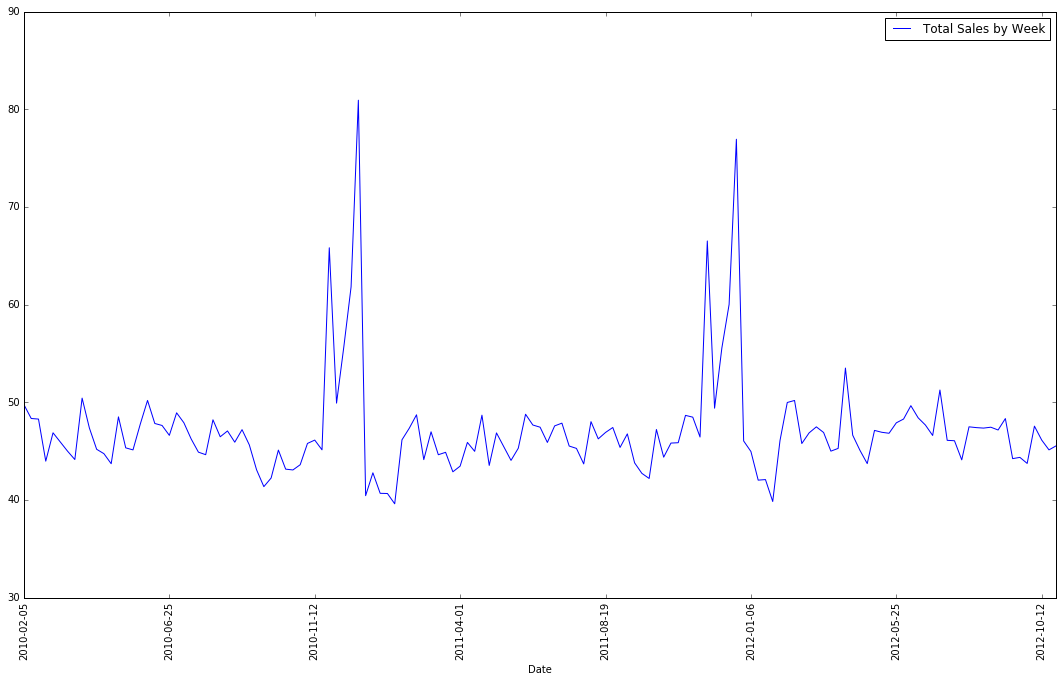

In [44]:
alldeptsales["total_sales"] = alldeptsales.loc[:,'d1':'d98'].sum(axis=1)
alldeptsales.plot('Date','total_sales',rot=90,label="Total Sales by Week")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

### Total sales across all departments and stores are also very cyclical with peaks around Thanksgiving and Christmas.

In [18]:
alldeptsales.shape

(143, 100)

In [19]:
df = alldeptsales
df[df==0] = np.nan
df=df.dropna(axis=1,how='all')
df.shape
depts = df.shape[1]

###  After cleaning up the pivot table, it looks like while the department numbers go up to 99, there are, in fact, only 81 departments since some numbers were skipped by all stores.

In [20]:
alldeptsales = df
#alldeptsales.columns

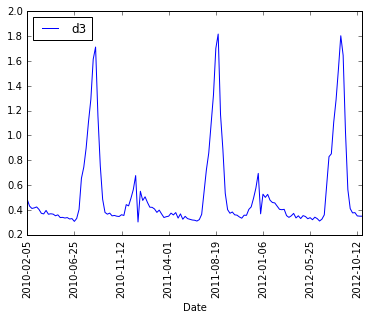

In [21]:
alldeptsales.plot('Date','d3',rot=90)

In [22]:
thresh = 0.9
dept3 = pd.DataFrame.from_items([('Date',dates),('d3',alldeptsales.d3)])
max = dept3['d3'].max()
min = dept3['d3'].min()
dept3ratio = max/min
dept3peaks = dept3[dept3['d3'] > dept3ratio*thresh*min]
peaks3 = pd.concat([dept3peaks['Date'], holiday.IsHoliday.iloc[dept3peaks.index]],axis=1)
print(peaks3)

           Date IsHoliday
29   2010-08-27     False
80   2011-08-19     False
81   2011-08-26     False
133  2012-08-24     False
134  2012-08-31     False


### Department 3 sales have singular peaks in the latter half of August, at the end of summer vacation.  Back-to-school items?

In [23]:
#Write a function that does sales peak detection
def salespeak(deptnum,threshold):
    dept = pd.DataFrame.from_items([('Date',dates),(deptnum,alldeptsales[deptnum])])
    max = dept[deptnum].max()
    min = dept[deptnum].min()
    deptratio = max/min
    if deptratio > 2:
        dept.plot('Date',deptnum,rot=90)
        return dept[dept[deptnum] > deptratio*threshold*min]
    else:
        print('No prominent peaks found')
        

In [24]:

salespeak('d4',0.9)


No prominent peaks found


### Department 4 sales is mostly flat and have very little seasonality.

,index,Date,0
0,42,2010-11-26,True
1,45,2010-12-17,True
2,46,2010-12-24,True
3,94,2011-11-25,True
4,98,2011-12-23,True


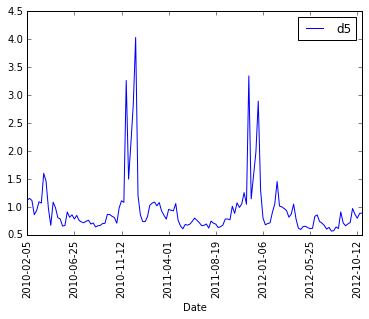

In [25]:
deptpeak = salespeak('d5',0.7)

# This function look designated number of weeks forward do we look for whether sales is leading to a holiday

def holiday_sales(window,deptpeak):
    temp = pd.Series(holiday.IsHoliday.iloc[deptpeak.index]).values 
    for i in range(1,window+1):
        temp = pd.Series(holiday.IsHoliday.iloc[deptpeak.index+i].values | temp)
    isholiday = pd.concat([deptpeak.Date.reset_index(),temp],axis=1)
    return isholiday

holiday_sales(2,deptpeak)


### Department 5 has peak sales during Thanksgiving and Christmas.

In [26]:
dept1 = ptrain1[ptrain1.index==1]
dept1.head(3)

Date Weekly_Sales                                          \
Store                       s1                                           
Dept                        d1       d10       d11       d12       d13   
1      2010-02-12     0.046039  0.031495  0.021761  0.008654  0.036476   

                                              ...                      \
Store                                         ...        s9             
Dept        d14       d16       d17       d18 ...        d9       d90   
1      0.018129  0.011874  0.013404  0.019006 ...  0.006557  0.002486   

                                                                           
Store                                                                      
Dept        d91       d92 d93       d94       d95       d96       d97 d98  
1      0.000545  0.011081 NaN  0.000983  0.022317  0.002304  0.000767 NaN  

[1 rows x 3332 columns]

In [27]:
def salesplot(s1,d1,s2,d2):
    deptsales1 = train[(train.Store==s1) & (train.Dept==d1)]
    deptsales2 = train[(train.Store==s2) & (train.Dept==d2)]
    ax = deptsales1.plot('Date','Weekly_Sales',kind='line',rot=90)
    deptsales2.plot('Date','Weekly_Sales',kind='line',rot=90,ax=ax)
#    plt.show()

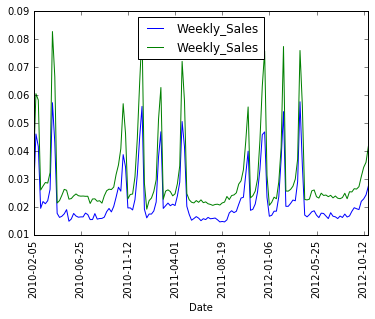

In [28]:
salesplot('s1','d1','s2','d1')

### You can see that the same department but in different stores exhibit similar patterns.

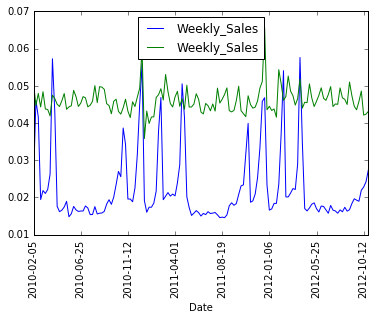

In [29]:
salesplot('s1','d1','s1','d2')

### On the contrary, different departments in the same store have very different patterns.  

Just re-affirming that same department, different stores yield same patterns

Again, reaffirming that within same store different departments yield very different patterns.  All departments in all stores seem to have regular cycles. 

Let's look at holiday vs non-holiday performance

In [30]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,s1,d1,2010-02-05,0.024924,False
1,s1,d1,2010-02-12,0.046039,True
2,s1,d1,2010-02-19,0.041596,False


Top Departments by Sales


,Dept,Weekly_Sales,IsHoliday
73,d92,483.943342,450
76,d95,449.320163,450
30,d38,393.118137,450
58,d72,305.725152,425
71,d90,291.068464,450


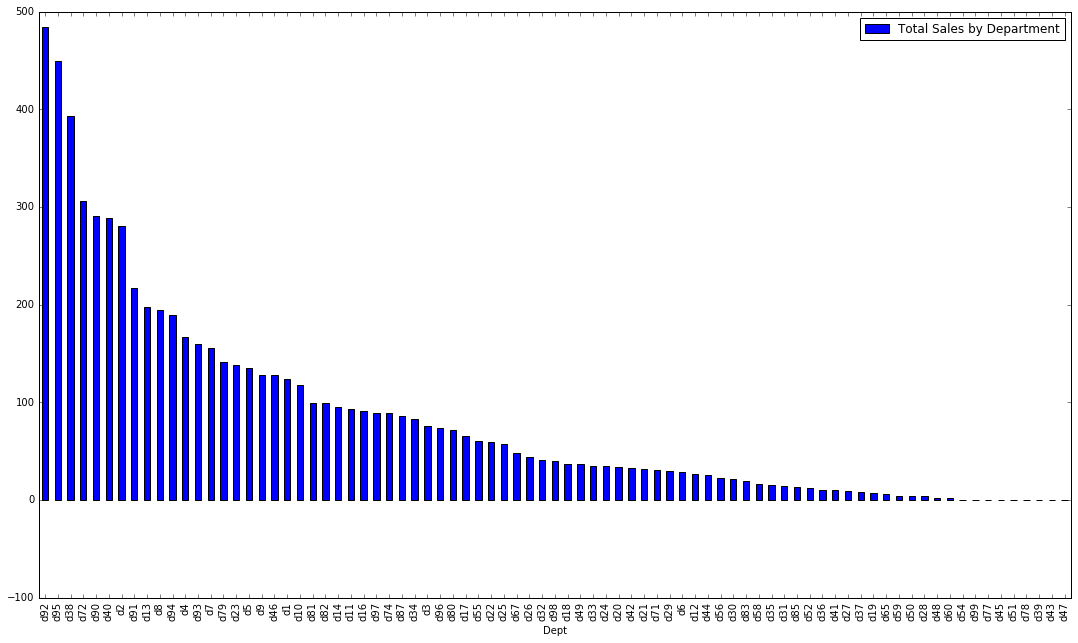

In [46]:
deptsums = train.groupby('Dept').sum()
deptsums.reset_index(inplace=True)
deptsums.drop(deptsums.Weekly_Sales==0)
#deptsums.plot('Dept','Weekly_Sales')
deptsumshilo=deptsums.sort_values('Weekly_Sales',ascending=False)
deptsumshilo.plot('Dept','Weekly_Sales',kind='bar',label='Total Sales by Department')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

print('Top Departments by Sales')
deptsumshilo.head(5)


### Distribution of total sales over the 2.5 year span of data has a very long tail.

In [32]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [33]:
test = pd.read_csv('test.csv')

In [34]:
stores = pd.read_csv('stores.csv')
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
